In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import random
from PIL import Image
from sklearn.model_selection import train_test_split

# Define paths and parameters
data_dir = '/content/drive/MyDrive/Vaay/Newset/Data/'
output_dir = '/content/drive/MyDrive/Train_test_val'
categories = {
    "airport_terminal": "Airport",
    "bakery/shop": "Bakery",
    "bowling_alley": "Bowling",
    "classroom": "classroom",
    "music_studio": "music_studio"
}
num_images_per_class = 500  # Total images per class
train_size = 350
val_size = 75
test_size = 75
resize_dim = (224, 224)

# Create output directories
for split in ['train', 'val', 'test']:
    for category in categories.values():
        os.makedirs(os.path.join(output_dir, split, category), exist_ok=True)

# Function to resize and save images
def resize_and_save(img_path, output_path):
    img = Image.open(img_path)
    img = img.resize(resize_dim, Image.ANTIALIAS)
    img.save(output_path)

# Process each category
for category_path, category_name in categories.items():
    full_category_path = os.path.join(data_dir, category_path)
    images = [os.path.join(full_category_path, img) for img in os.listdir(full_category_path) if img.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    # Shuffle and select a subset of images
    random.shuffle(images)
    images = images[:num_images_per_class]

    # Split images into training, validation, and test sets
    train_images, test_images = train_test_split(images, test_size=(val_size + test_size) / num_images_per_class, random_state=42)
    val_images, test_images = train_test_split(test_images, test_size=test_size / (val_size + test_size), random_state=42)

    # Print the number of images in each set
    print(f"{category_name}:")
    print(f"  Training: {len(train_images)}")
    print(f"  Validation: {len(val_images)}")
    print(f"  Testing: {len(test_images)}")

    # Resize and save images to respective directories
    for img_path in train_images:
        resize_and_save(img_path, os.path.join(output_dir, 'train', category_name, os.path.basename(img_path)))
    for img_path in val_images:
        resize_and_save(img_path, os.path.join(output_dir, 'val', category_name, os.path.basename(img_path)))
    for img_path in test_images:
        resize_and_save(img_path, os.path.join(output_dir, 'test', category_name, os.path.basename(img_path)))

print("Dataset preparation completed.")

Airport:
  Training: 350
  Validation: 75
  Testing: 75


<ipython-input-8-bed7a5af9aea>:31: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(resize_dim, Image.ANTIALIAS)


Bakery:
  Training: 350
  Validation: 75
  Testing: 75
Bowling:
  Training: 350
  Validation: 75
  Testing: 75
classroom:
  Training: 350
  Validation: 75
  Testing: 75
music_studio:
  Training: 350
  Validation: 75
  Testing: 75
Dataset preparation completed.


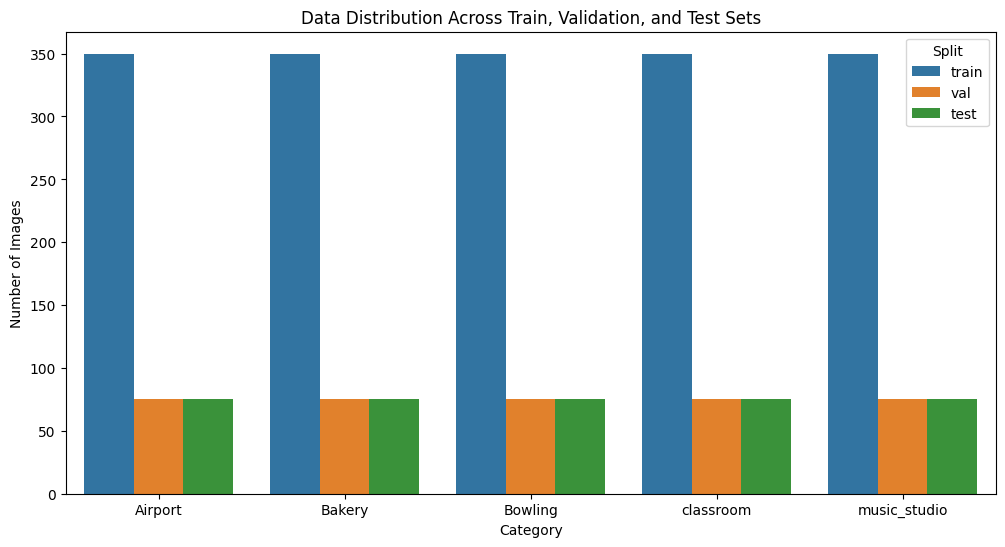

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Calculate the number of images in each category for each split
data_counts = {'Category': [], 'Split': [], 'Count': []}

for split in ['train', 'val', 'test']:
    for category in categories.values():
        category_path = os.path.join(output_dir, split, category)
        count = len(os.listdir(category_path))
        data_counts['Category'].append(category)
        data_counts['Split'].append(split)
        data_counts['Count'].append(count)

# Convert to DataFrame for easier plotting
data_counts_df = pd.DataFrame(data_counts)

# Plot the distribution of data
plt.figure(figsize=(12, 6))
sns.barplot(x='Category', y='Count', hue='Split', data=data_counts_df)
plt.title('Data Distribution Across Train, Validation, and Test Sets')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.legend(title='Split')
plt.show()

Dataset sizes: {'train': 1750, 'val': 375, 'test': 375}
Class names: ['Airport', 'Bakery', 'Bowling', 'classroom', 'music_studio']


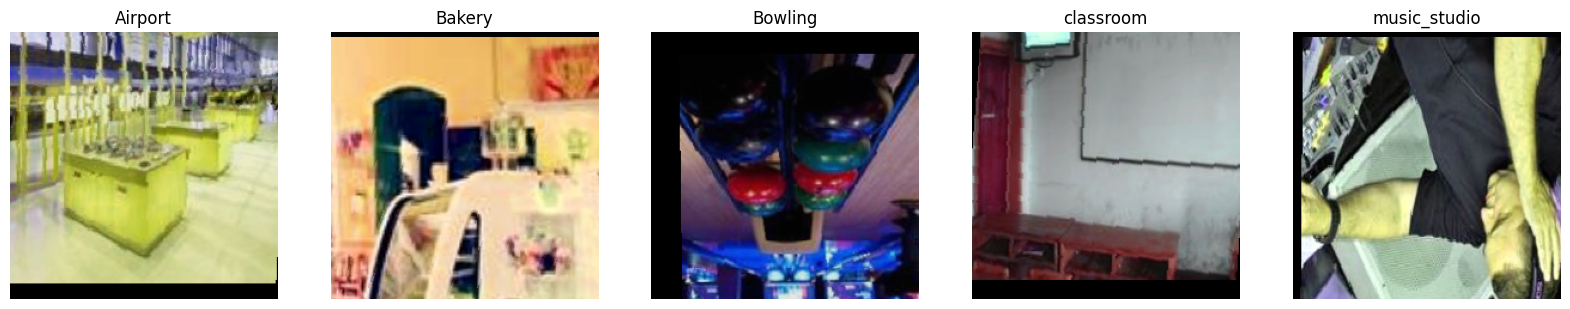

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
import numpy as np
import os

# Enable benchmark mode in cuDNN for performance
cudnn.benchmark = True

# Define data augmentation and preprocessing steps
resize_dim = (224, 224)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),         # Randomly flip images horizontally
        transforms.RandomVerticalFlip(),           # Randomly flip images vertically
        transforms.RandomRotation(5),              # Randomly rotate images by 5 degrees
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Randomly change brightness, contrast, saturation, and hue
        transforms.RandomResizedCrop(resize_dim),  # Randomly resize and crop images to the specified dimensions
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),  # Apply random affine transformations
        transforms.ToTensor(),                     # Convert images to tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize images
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(resize_dim),         # Crop the center of the images
        transforms.ToTensor(),                     # Convert images to tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize images
    ]),
    'test': transforms.Compose([
        transforms.CenterCrop(resize_dim),         # Crop the center of the images
        transforms.ToTensor(),                     # Convert images to tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize images
    ]),
}

# Create datasets with ImageFolder
data_dir = '/content/drive/MyDrive/Train_test_val'
image_datasets = {x: ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

# Create data loaders with adjusted num_workers
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2, pin_memory=True) for x in ['train', 'val', 'test']}

# Check the sizes of datasets
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

print("Dataset sizes:", dataset_sizes)
print("Class names:", class_names)

# Function to display an image
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Get one image from each class
def get_one_image_per_class(dataset):
    class_to_idx = dataset.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    images = {class_name: None for class_name in class_to_idx.keys()}

    for img, label in dataset:
        class_name = idx_to_class[label]
        if images[class_name] is None:
            images[class_name] = (img, class_name)
        if all(images.values()):
            break
    return images

# Display one image from each class
train_dataset = image_datasets['train']
one_image_per_class = get_one_image_per_class(train_dataset)

plt.figure(figsize=(20, 10))
for i, (img, class_name) in enumerate(one_image_per_class.values()):
    ax = plt.subplot(1, len(one_image_per_class), i + 1)
    imshow(img, title=class_name)
    ax.axis('off')

plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
import torch.backends.cudnn as cudnn

cudnn.benchmark = True

def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, scheduler=None, num_epochs=50):
    scaler = GradScaler()  # Initialize gradient scaler for mixed precision training

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to('cuda')
                labels = labels.to('cuda')

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    with autocast():  # Mixed precision context
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train' and scheduler:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 56 * 56, 120)
        self.fc2 = nn.Linear(120, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize and train the SimpleCNN model
model1 = SimpleCNN().to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)
train_model(model1, criterion, optimizer, dataloaders, dataset_sizes)


Epoch 0/24
----------
train Loss: 2.0374 Acc: 0.2560
val Loss: 1.5053 Acc: 0.3760
Epoch 1/24
----------
train Loss: 1.4674 Acc: 0.3829
val Loss: 1.3598 Acc: 0.4507
Epoch 2/24
----------
train Loss: 1.4153 Acc: 0.4154
val Loss: 1.3946 Acc: 0.4160
Epoch 3/24
----------
train Loss: 1.3996 Acc: 0.4131
val Loss: 1.3095 Acc: 0.4933
Epoch 4/24
----------
train Loss: 1.3814 Acc: 0.4297
val Loss: 1.3368 Acc: 0.4747
Epoch 5/24
----------
train Loss: 1.3764 Acc: 0.4406
val Loss: 1.3482 Acc: 0.4427
Epoch 6/24
----------
train Loss: 1.3542 Acc: 0.4411
val Loss: 1.2633 Acc: 0.5067
Epoch 7/24
----------
train Loss: 1.3570 Acc: 0.4411
val Loss: 1.2725 Acc: 0.5120
Epoch 8/24
----------
train Loss: 1.3239 Acc: 0.4429
val Loss: 1.3362 Acc: 0.4720
Epoch 9/24
----------
train Loss: 1.3331 Acc: 0.4480
val Loss: 1.2743 Acc: 0.5067
Epoch 10/24
----------
train Loss: 1.3406 Acc: 0.4349
val Loss: 1.2183 Acc: 0.5333
Epoch 11/24
----------
train Loss: 1.3210 Acc: 0.4554
val Loss: 1.2586 Acc: 0.4933
Epoch 12/24
--

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=5, bias=True)
)

In [ ]:
from torchvision import transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader

data_dir = '/content/drive/MyDrive/Train_test_val'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

import torch.nn as nn
import torch.nn.functional as F

class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, len(class_names)),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
import torch.backends.cudnn as cudnn

cudnn.benchmark = True

model = DeepCNN().to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
scaler = GradScaler()  # Initialize the scaler for mixed precision training


In [ ]:
import time
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to('cuda')
                labels = labels.to('cuda')

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    with autocast():
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
model5 = train_model(model, criterion, optimizer, scheduler, num_epochs=50)


Epoch 0/49
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 1.7508 Acc: 0.2337
val Loss: 1.5491 Acc: 0.3413
Epoch 1/49
----------
train Loss: 1.5691 Acc: 0.3560
val Loss: 1.4085 Acc: 0.4027
Epoch 2/49
----------
train Loss: 1.4836 Acc: 0.3920
val Loss: 1.3911 Acc: 0.4667
Epoch 3/49
----------
train Loss: 1.4497 Acc: 0.3994
val Loss: 1.3021 Acc: 0.4933
Epoch 4/49
----------
train Loss: 1.4154 Acc: 0.4183
val Loss: 1.2678 Acc: 0.4933
Epoch 5/49
----------
train Loss: 1.4027 Acc: 0.4297
val Loss: 1.3028 Acc: 0.4800
Epoch 6/49
----------
train Loss: 1.3941 Acc: 0.4314
val Loss: 1.2691 Acc: 0.4827
Epoch 7/49
----------
train Loss: 1.3960 Acc: 0.4291
val Loss: 1.2511 Acc: 0.5440
Epoch 8/49
----------
train Loss: 1.3892 Acc: 0.4429
val Loss: 1.2086 Acc: 0.5600
Epoch 9/49
----------
train Loss: 1.3651 Acc: 0.4360
val Loss: 1.2634 Acc: 0.5040
Epoch 10/49
----------
train Loss: 1.3604 Acc: 0.4451
val Loss: 1.7364 Acc: 0.3600
Epoch 11/49
----------
train Loss: 1.3545 Acc: 0.4417
val Loss: 1.1507 Acc: 0.5973
Epoch 12/49
----------
train Loss: 1

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Save paths
save_path_model1 = '/content/drive/MyDrive/model1.pth'
save_path_model5 = '/content/drive/MyDrive/model5.pth'

# Save Model 1
torch.save(model1.state_dict(), save_path_model1)
print(f'Model 1 saved to {save_path_model1}')

# Save Model 5
torch.save(model5.state_dict(), save_path_model5)
print(f'Model 5 saved to {save_path_model5}')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model 1 saved to /content/drive/MyDrive/model1.pth
Model 2 saved to /content/drive/MyDrive/model2.pth
Model 3 saved to /content/drive/MyDrive/model3.pth
Model 5 saved to /content/drive/MyDrive/model5.pth


In [ ]:
train_losses_model5 = [1.7508, 1.5691, 1.4836, 1.4497, 1.4154, 1.4027, 1.3941, 1.3960, 1.3892, 1.3651, 1.3604, 1.3545, 1.3003, 1.2782, 1.3133, 1.2649, 1.2513, 1.2652, 1.2228, 1.2161, 1.2078, 1.1906, 1.1965, 1.1160, 1.1517, 1.0953, 1.0705, 1.0841, 1.0481, 1.0567, 1.0160, 0.9945, 0.9819, 0.9727, 0.9665, 0.9252, 0.9296, 0.8955, 0.8777, 0.8701, 0.8606, 0.8674, 0.8499, 0.8542, 0.8029, 0.8601, 0.8544, 0.8303, 0.8216, 0.8189]
val_losses_model5 = [1.5491, 1.4085, 1.3911, 1.3021, 1.2678, 1.3028, 1.2691, 1.2511, 1.2086, 1.2634, 1.7364, 1.1507, 1.1880, 1.4039, 1.1270, 1.2022, 1.1567, 1.1084, 1.0420, 1.0521, 1.0634, 1.1113, 1.0074, 1.0508, 1.0891, 0.9419, 0.9705, 0.9896, 0.9012, 0.9540, 0.9655, 0.9167, 0.8508, 0.9608, 0.8142, 0.8918, 0.8425, 0.7960, 0.7578, 0.7695, 0.7733, 0.7327, 0.7347, 0.7307, 0.7215, 0.7152, 0.7087, 0.7057, 0.7078, 0.7038]


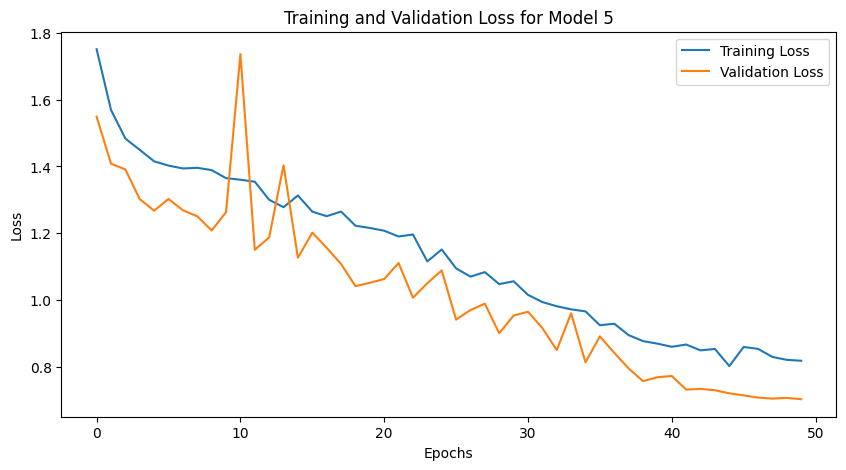

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training and validation loss
def plot_losses(train_losses, val_losses, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss for {model_name}')
    plt.legend()
    plt.show()

plot_losses(train_losses_model5, val_losses_model5, 'Model 5')


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Model Test Accuracy: 68.80%


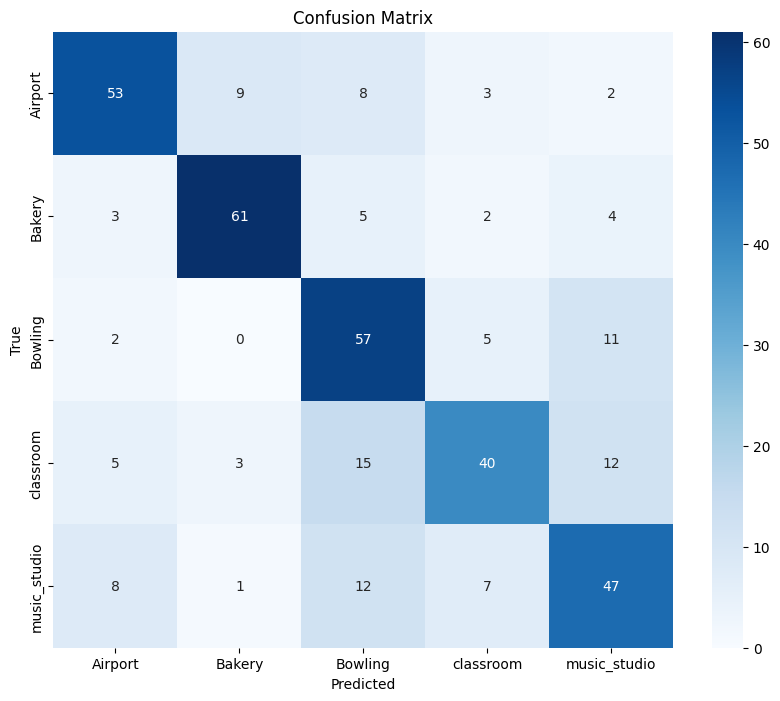

Classification Report:
              precision    recall  f1-score   support

     Airport       0.75      0.71      0.73        75
      Bakery       0.82      0.81      0.82        75
     Bowling       0.59      0.76      0.66        75
   classroom       0.70      0.53      0.61        75
music_studio       0.62      0.63      0.62        75

    accuracy                           0.69       375
   macro avg       0.70      0.69      0.69       375
weighted avg       0.70      0.69      0.69       375



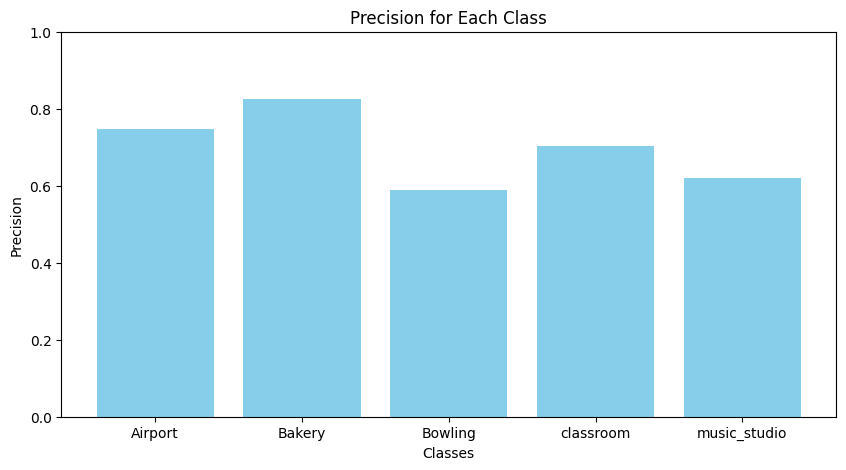

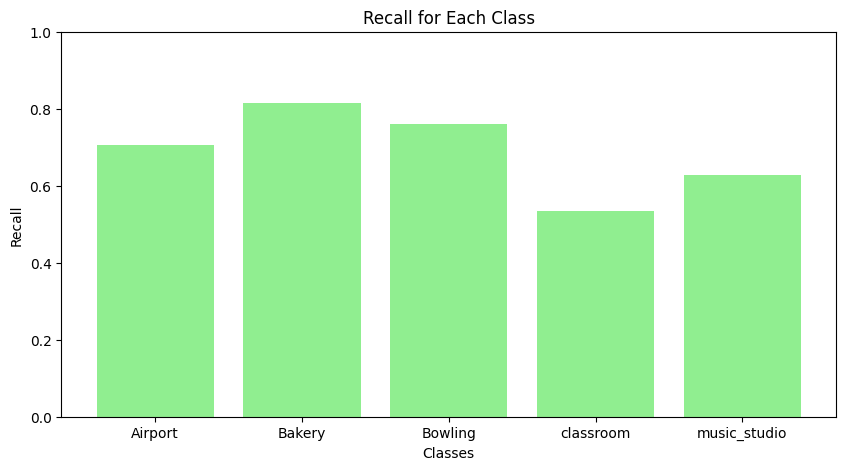

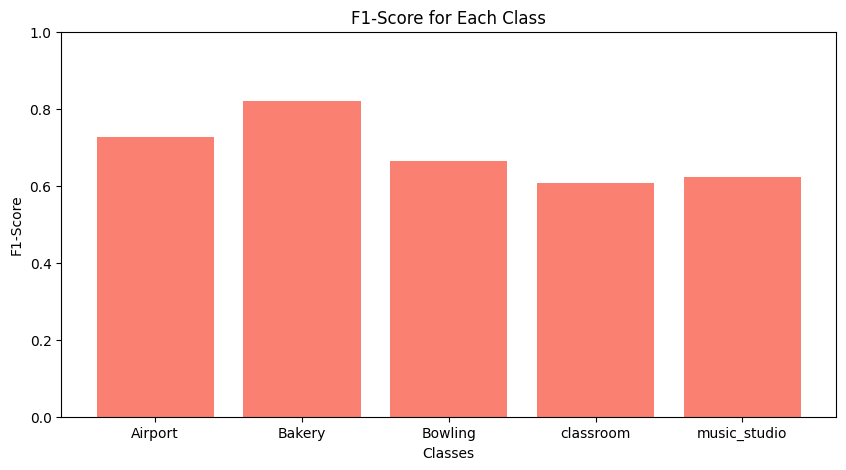

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the model class
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 5),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Load the model state dictionary
model5 = DeepCNN().to(device)
load_path_model5 = '/content/drive/MyDrive/model5.pth'
model5.load_state_dict(torch.load(load_path_model5, map_location=device))

# Load the test data
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_dir = '/content/drive/MyDrive/Train_test_val/test'
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Function to evaluate the model and compute metrics
def evaluate_and_plot(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=test_dataset.classes, output_dict=True)

    return accuracy, cm, cr, all_labels, all_preds

# Evaluate the model
accuracy, cm, cr, all_labels, all_preds = evaluate_and_plot(model5, test_loader, device)

print(f'Model Test Accuracy: {accuracy:.2f}%')

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(np.array(all_labels), np.array(all_preds), target_names=test_dataset.classes))

# Extract precision, recall, f1-score, and accuracy for each class
classes = list(cr.keys())[:-3]  # Exclude 'accuracy', 'macro avg', and 'weighted avg'
precision = [cr[cls]['precision'] for cls in classes]
recall = [cr[cls]['recall'] for cls in classes]
f1_score_values = [cr[cls]['f1-score'] for cls in classes]
accuracy_per_class = [cr[cls]['support'] for cls in classes]
accuracy_per_class = [accuracy * accuracy_per_class[idx] / sum(accuracy_per_class) for idx, accuracy in enumerate(accuracy_per_class)]

# Plot Precision
plt.figure(figsize=(10, 5))
plt.bar(classes, precision, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Precision')
plt.title('Precision for Each Class')
plt.ylim(0, 1)
plt.show()

# Plot Recall
plt.figure(figsize=(10, 5))
plt.bar(classes, recall, color='lightgreen')
plt.xlabel('Classes')
plt.ylabel('Recall')
plt.title('Recall for Each Class')
plt.ylim(0, 1)
plt.show()

# Plot F1-Score
plt.figure(figsize=(10, 5))
plt.bar(classes, f1_score_values, color='salmon')
plt.xlabel('Classes')
plt.ylabel('F1-Score')
plt.title('F1-Score for Each Class')
plt.ylim(0, 1)
plt.show()

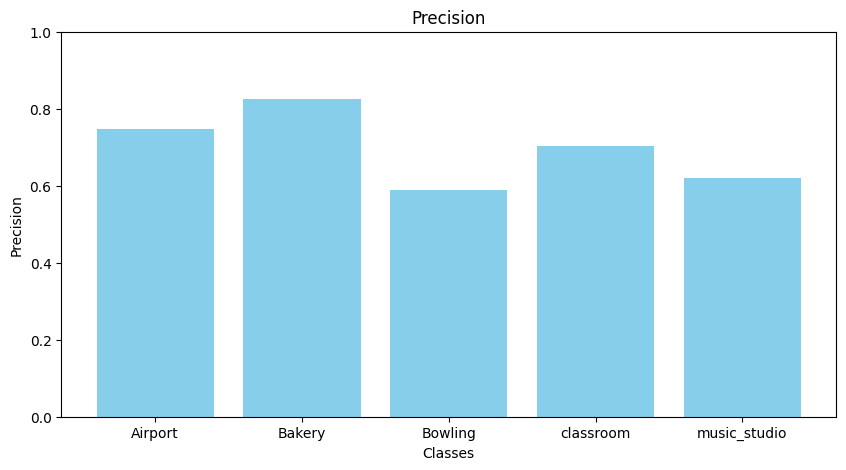

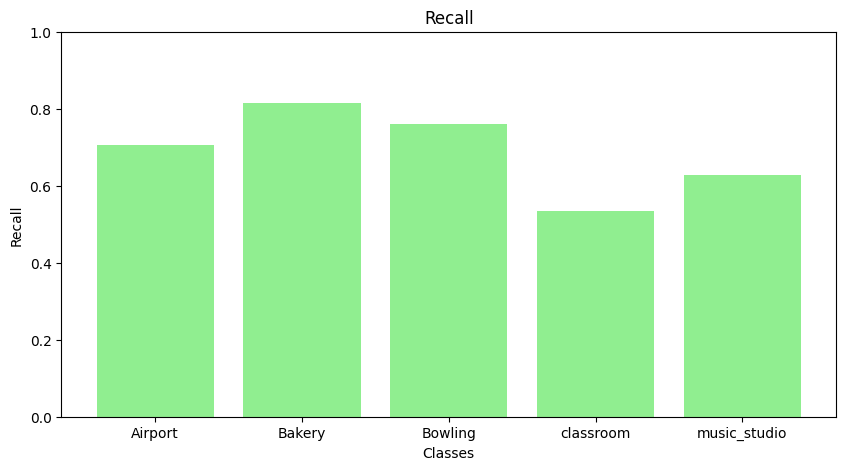

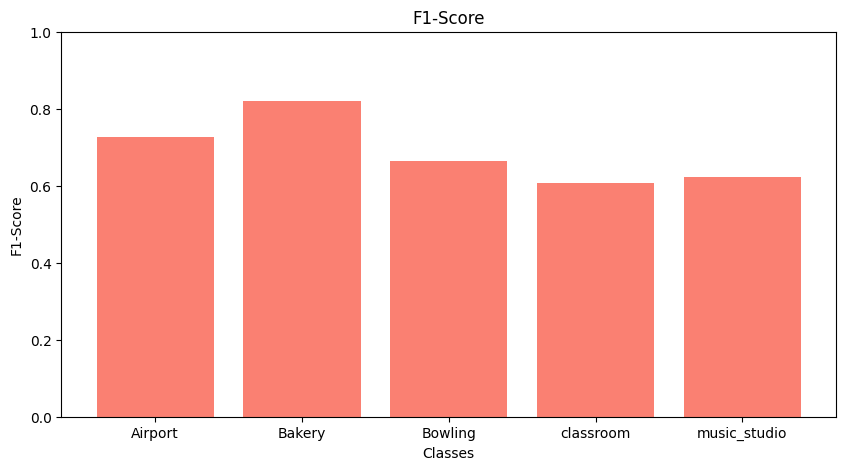

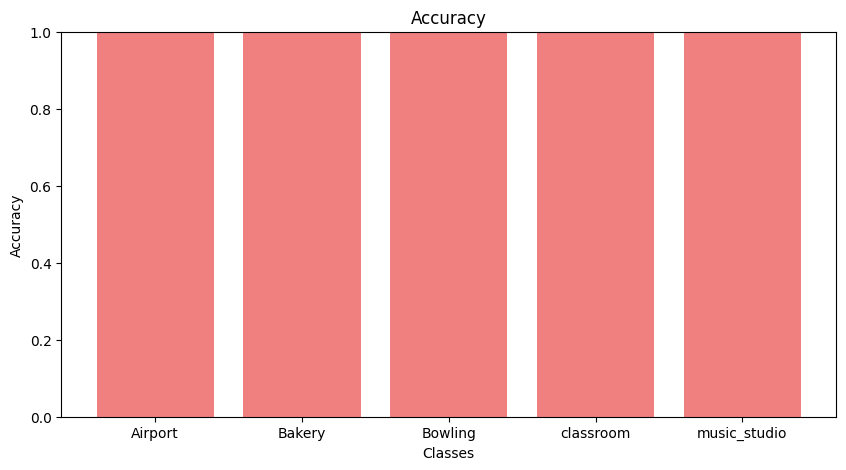

In [ ]:
# Extract precision, recall, f1-score, and accuracy for each class
classes = list(cr.keys())[:-3]  # Exclude 'accuracy', 'macro avg', and 'weighted avg'
precision = [cr[cls]['precision'] for cls in classes]
recall = [cr[cls]['recall'] for cls in classes]
f1_score_values = [cr[cls]['f1-score'] for cls in classes]
accuracy_per_class = [cr[cls]['support'] for cls in classes]
accuracy_per_class = [accuracy * accuracy_per_class[idx] / sum(accuracy_per_class) for idx, accuracy in enumerate(accuracy_per_class)]

# Plot Precision
plt.figure(figsize=(10, 5))
plt.bar(classes, precision, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Precision')
plt.title('Precision')
plt.ylim(0, 1)
plt.show()

# Plot Recall
plt.figure(figsize=(10, 5))
plt.bar(classes, recall, color='lightgreen')
plt.xlabel('Classes')
plt.ylabel('Recall')
plt.title('Recall')
plt.ylim(0, 1)
plt.show()

# Plot F1-Score
plt.figure(figsize=(10, 5))
plt.bar(classes, f1_score_values, color='salmon')
plt.xlabel('Classes')
plt.ylabel('F1-Score')
plt.title('F1-Score')
plt.ylim(0, 1)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.bar(classes, accuracy_per_class, color='lightcoral')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.ylim(0, 1)
plt.show()


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Model 1 Test Accuracy: 50.40%


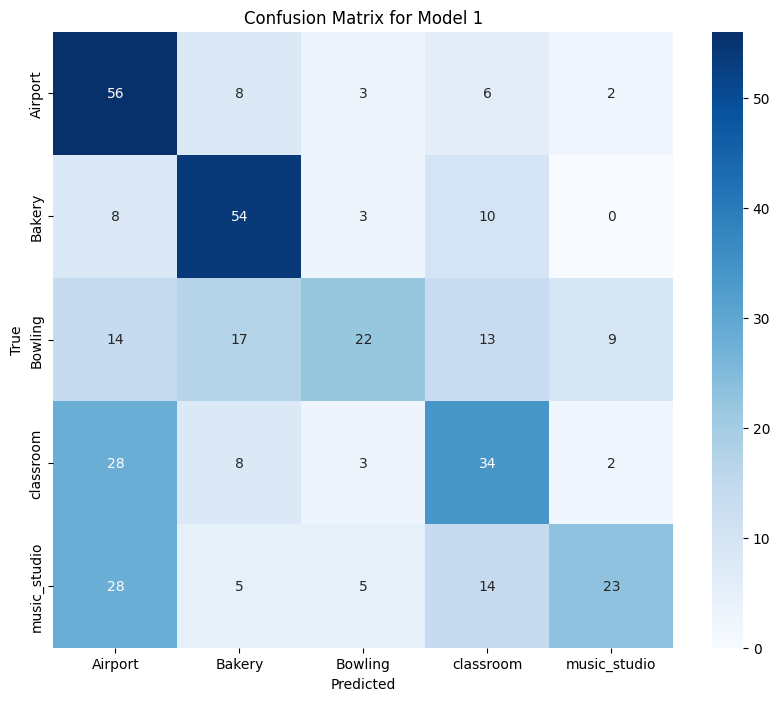

Classification Report for Model 1:
              precision    recall  f1-score   support

     Airport       0.42      0.75      0.54        75
      Bakery       0.59      0.72      0.65        75
     Bowling       0.61      0.29      0.40        75
   classroom       0.44      0.45      0.45        75
music_studio       0.64      0.31      0.41        75

    accuracy                           0.50       375
   macro avg       0.54      0.50      0.49       375
weighted avg       0.54      0.50      0.49       375



In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define Model 1 Class
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 56 * 56, 120)
        self.fc2 = nn.Linear(120, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load the model state dictionary
model1 = BasicCNN().to(device)
load_path_model1 = '/content/drive/MyDrive/model1.pth'
model1.load_state_dict(torch.load(load_path_model1, map_location=device))

# Load the test data
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_dir = '/content/drive/MyDrive/Train_test_val/test'
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Function to evaluate the model and compute metrics
def evaluate_and_plot(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=test_dataset.classes, output_dict=True)

    return accuracy, cm, cr, all_labels, all_preds

# Evaluate Model 1
accuracy1, cm1, cr1, all_labels1, all_preds1 = evaluate_and_plot(model1, test_loader, device)
print(f'Model 1 Test Accuracy: {accuracy1:.2f}%')

# Plot confusion matrix for Model 1
plt.figure(figsize=(10, 8))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Model 1')
plt.show()

# Print classification report for Model 1
print('Classification Report for Model 1:')
print(classification_report(np.array(all_labels1), np.array(all_preds1), target_names=test_dataset.classes))


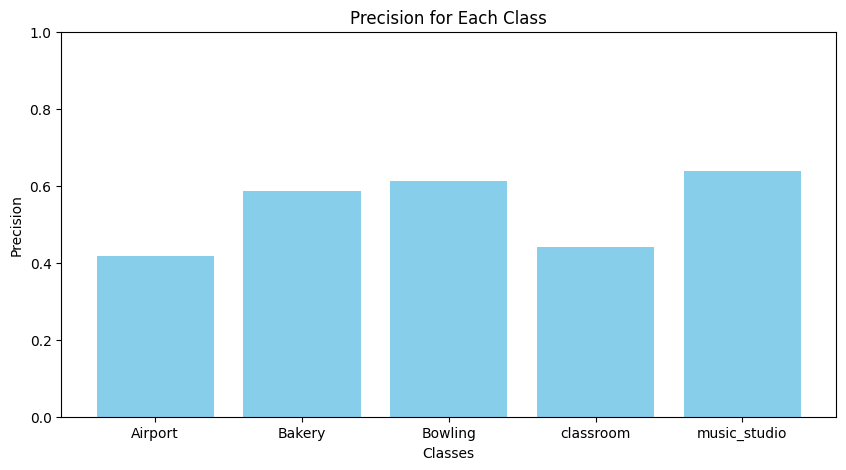

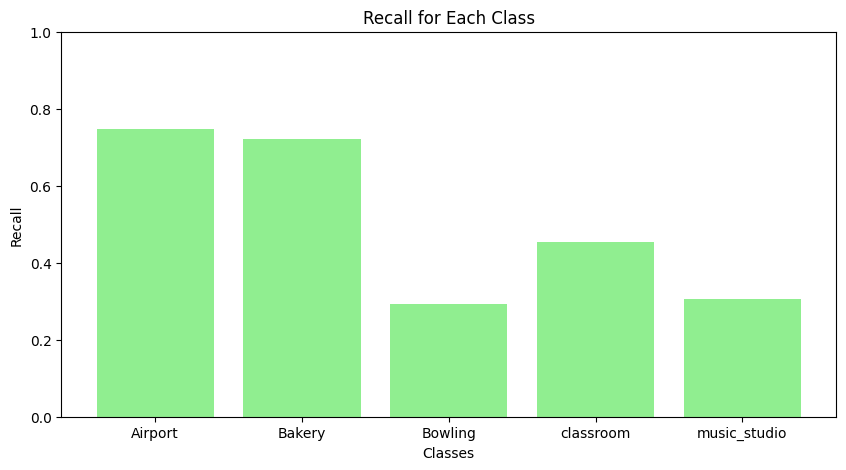

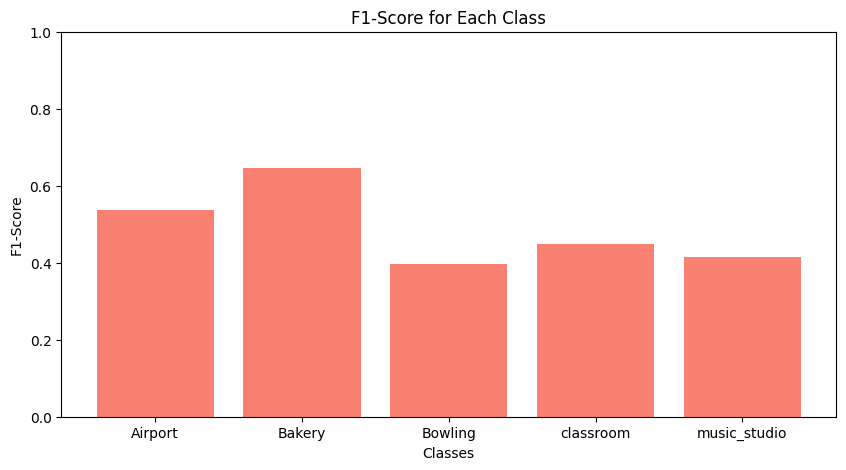

In [ ]:
# Extract precision, recall, f1-score, and accuracy for each class for Model 1
classes = list(cr1.keys())[:-3]  # Exclude 'accuracy', 'macro avg', and 'weighted avg'
precision = [cr1[cls]['precision'] for cls in classes]
recall = [cr1[cls]['recall'] for cls in classes]
f1_score_values = [cr1[cls]['f1-score'] for cls in classes]

# Plot Precision
plt.figure(figsize=(10, 5))
plt.bar(classes, precision, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Precision')
plt.title('Precision for Each Class')
plt.ylim(0, 1)
plt.show()

# Plot Recall
plt.figure(figsize=(10, 5))
plt.bar(classes, recall, color='lightgreen')
plt.xlabel('Classes')
plt.ylabel('Recall')
plt.title('Recall for Each Class')
plt.ylim(0, 1)
plt.show()

# Plot F1-Score
plt.figure(figsize=(10, 5))
plt.bar(classes, f1_score_values, color='salmon')
plt.xlabel('Classes')
plt.ylabel('F1-Score')
plt.title('F1-Score for Each Class')
plt.ylim(0, 1)
plt.show()


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F

# Define Model 5 Class
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 5)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Function to load the model and make a prediction on a single image
def predict_image(image_path, model_path, device, class_names):
    # Load the model
    model = DeepCNN().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Define the image transformation
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Load and transform the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension

    # Move the image to the device
    image = image.to(device)

    # Make the prediction
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    return class_names[predicted.item()]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = '/content/drive/MyDrive/model5.pth'
image_path = '/content/drive/MyDrive/airport_image.jpg'
class_names = ['airport_terminal', 'bakery/shop', 'bowling_alley', 'classroom', 'music_studio']

predicted_class = predict_image(image_path, model_path, device, class_names)
print(f'Predicted class: {predicted_class}')


Predicted class: airport_terminal
